# DecisionTreeDiscretiser

The DecisionTreeDiscretiser() divides continuous numerical variables into discrete, finite, values estimated by a decision tree.

The methods is inspired by the following article from the winners of the KDD 2009 competition:
http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf

**Note**

For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser

plt.rcParams["figure.figsize"] = [15,5]

## DecisionTreeDiscretiser with Regression

In [15]:
# data = pd.read_csv('../data/housing.csv')
# data.head()

# # let's separate into training and testing set
# X = data.drop(["Id", "SalePrice"], axis=1)
# y = data.SalePrice

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print("X_train :", X_train.shape)
# print("X_test :", X_test.shape)

In [16]:
# Read the separate files
train_df = pd.read_csv('../data/house-prices/train.csv')
test_df = pd.read_csv('../data/house-prices/test.csv')

# Separate features and target in training data
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = train_df['SalePrice']

# For test data, you might not have the target variable
X_test = test_df.drop(['Id'], axis=1)  # Note: test data might not have SalePrice column

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (1460, 79)
X_test : (1459, 79)


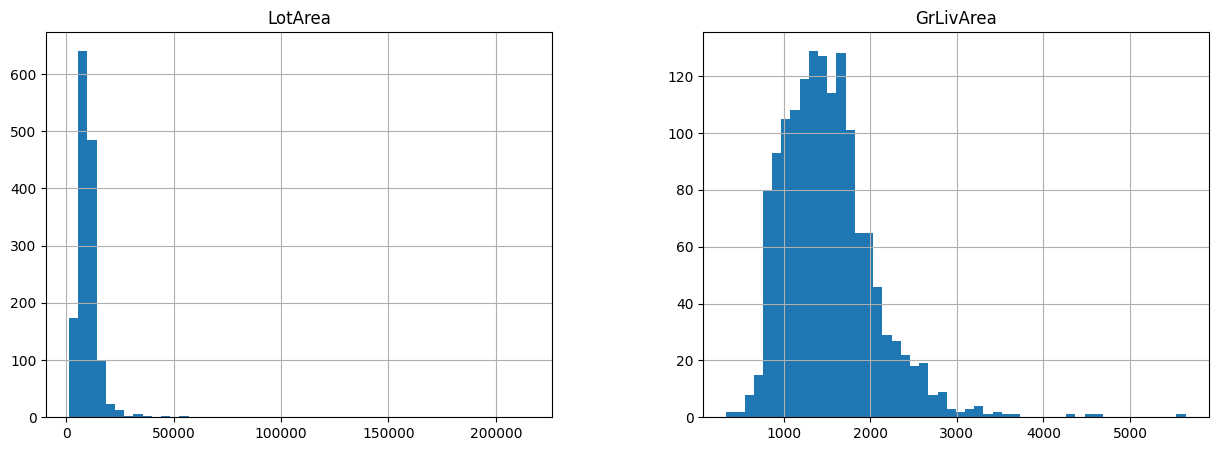

In [17]:
# we will discretise two continuous variables

X_train[["LotArea", 'GrLivArea']].hist(bins=50)
plt.show()

The DecisionTreeDiscretiser() works only with numerical variables.
A list of variables can be passed as an argument. Alternatively, the
discretiser will automatically select and transform all numerical variables.

The DecisionTreeDiscretiser() first trains a decision tree for each variable,
fit.

The DecisionTreeDiscretiser() then transforms the variables, that is,
makes predictions based on the variable values, using the trained decision
tree, transform.

In [18]:
'''
Parameters
----------

cv : int, default=3
    Desired number of cross-validation fold to be used to fit the decision
    tree.

scoring: str, default='neg_mean_squared_error'
    Desired metric to optimise the performance for the tree. Comes from
    sklearn metrics. See DecisionTreeRegressor or DecisionTreeClassifier
    model evaluation documentation for more options:
    https://scikit-learn.org/stable/modules/model_evaluation.html

variables : list
    The list of numerical variables that will be transformed. If None, the
    discretiser will automatically select all numerical type variables.

regression : boolean, default=True
    Indicates whether the discretiser should train a regression or a classification
    decision tree.

param_grid : dictionary, default=None
    The list of parameters over which the decision tree should be optimised
    during the grid search. The param_grid can contain any of the permitted
    parameters for Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier().

    If None, then param_grid = {'max_depth': [1, 2, 3, 4]}

random_state : int, default=None
    The random_state to initialise the training of the decision tree. It is one
    of the parameters of the Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier(). For reproducibility it is recommended to set
    the random_state to an integer.
'''

treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='neg_mean_squared_error',
                                   variables=['LotArea', 'GrLivArea'],
                                   regression=True,
                                   random_state=29)

# the DecisionTreeDiscretiser needs the target for fitting
treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(random_state=29, variables=['LotArea', 'GrLivArea'])

In [19]:
# the binner_dict_ contains the best decision tree for each variable
treeDisc.binner_dict_

{'LotArea': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=29),
              param_grid={'max_depth': [1, 2, 3, 4]},
              scoring='neg_mean_squared_error'),
 'GrLivArea': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=29),
              param_grid={'max_depth': [1, 2, 3, 4]},
              scoring='neg_mean_squared_error')}

In [20]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [21]:
# the below account for the best obtained bins, aka, the tree predictions

train_t['GrLivArea'].unique()

array([197442.16893733, 152815.83673469, 239358.13362069, 124965.92857143,
       313656.01136364,  89009.80851064, 172635.48453608, 490791.66666667])

In [22]:
# the below account for the best obtained bins, aka, the tree predictions

train_t['LotArea'].unique()

array([144116.11131387, 176199.7833698 , 214277.47191011, 252308.14361702])

In [23]:
# here I put side by side the original variable and the transformed variable

tmp = pd.concat([X_train[["LotArea", 'GrLivArea']],
                 train_t[["LotArea", 'GrLivArea']]], axis=1)

tmp.columns = ["LotArea", 'GrLivArea', "LotArea_binned", 'GrLivArea_binned']

tmp.head()

,LotArea,GrLivArea,LotArea_binned,GrLivArea_binned
0,8450,1710,144116.111314,197442.168937
1,9600,1262,176199.783370,152815.836735
2,11250,1786,214277.471910,197442.168937
3,9550,1717,176199.783370,197442.168937
4,14260,2198,252308.143617,239358.133621


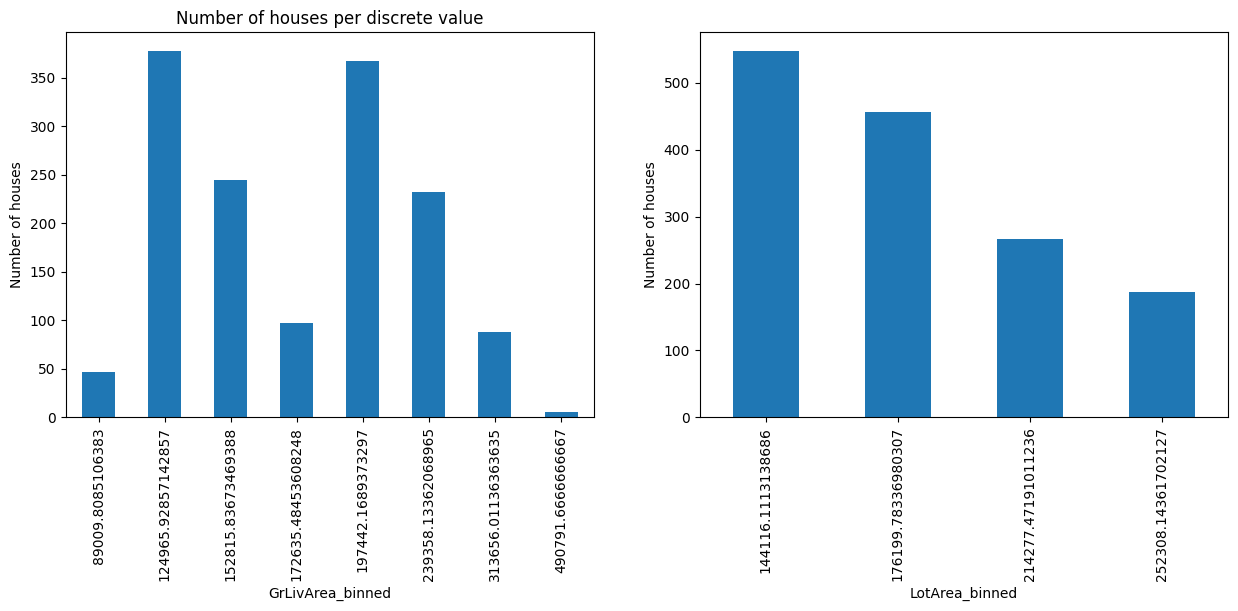

In [24]:
# in  equal frequency discretisation, we obtain the same amount of observations
# in each one of the bins.

plt.subplot(1,2,1)
tmp.groupby('GrLivArea_binned')['GrLivArea'].count().plot.bar()
plt.ylabel('Number of houses')
plt.title('Number of houses per discrete value')

plt.subplot(1,2,2)
tmp.groupby('LotArea_binned')['LotArea'].count().plot.bar()
plt.ylabel('Number of houses')
plt.ylabel('Number of houses')

plt.show()

## DecisionTreeDiscretiser with binary classification

In [25]:
# Load titanic dataset from file

def load_titanic(filepath='titanic.csv'):
    # data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = pd.read_csv(filepath)
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    # data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [26]:
# data = load_titanic("../data/titanic.csv")
data = load_titanic("../data/titanic-2/Titanic-Dataset.csv")
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S


In [27]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['survived'], axis=1),
                                                    data['survived'],
                                                    test_size=0.3, 
                                                    random_state=0)

print(X_train.shape)
print(X_test.shape)

(623, 11)
(268, 11)


In [28]:
#this discretiser transforms the numerical variables
X_train[['fare', 'age']].dtypes

fare    float64
age     float64
dtype: object

In [29]:
treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='roc_auc',
                                   variables=['fare', 'age'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2]},
                                   random_state=29,
                                   )

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(param_grid={'max_depth': [1, 2]}, random_state=29,
                        regression=False, scoring='roc_auc',
                        variables=['fare', 'age'])

In [30]:
treeDisc.binner_dict_

{'fare': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [1, 2]}, scoring='roc_auc'),
 'age': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [1, 2]}, scoring='roc_auc')}

In [31]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [32]:
# the below account for the best obtained bins
# in this case, the tree has found that dividing the data in 6 bins is enough
train_t['age'].unique()

array([0.41015625, 0.55769231, 0.33225806, 1.        ])

In [33]:
# the below account for the best obtained bins
# in this case, the tree has found that dividing the data in 8 bins is enough
train_t['fare'].unique()

array([0.44230769, 0.74626866, 0.25531915, 0.10714286])

In [34]:
# here I put side by side the original variable and the transformed variable

tmp = pd.concat([X_train[["fare", 'age']], train_t[["fare", 'age']]], axis=1)

tmp.columns = ["fare", 'age', "fare_binned", 'age_binned']

tmp.head()

,fare,age,fare_binned,age_binned
857,26.5500,51.0,0.442308,0.410156
52,76.7292,49.0,0.746269,0.410156
386,46.9000,1.0,0.442308,0.557692
124,77.2875,54.0,0.746269,0.410156
578,14.4583,28.0,0.442308,0.332258


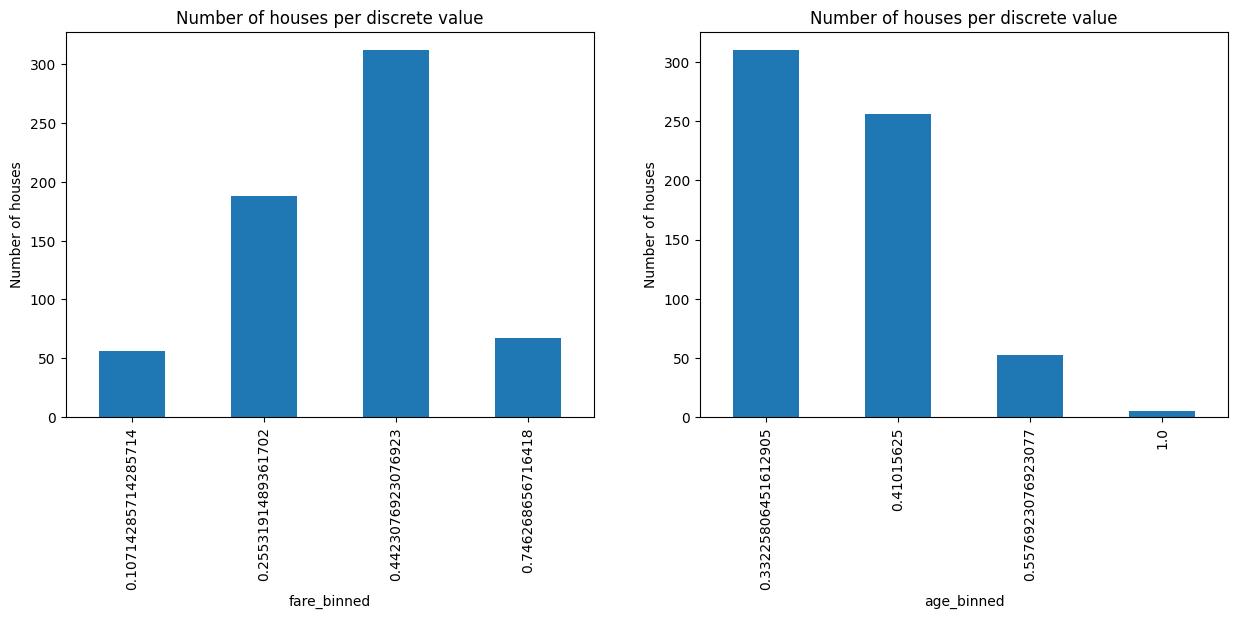

In [35]:
plt.subplot(1,2,1)
tmp.groupby('fare_binned')['fare'].count().plot.bar()
plt.ylabel('Number of houses')
plt.title('Number of houses per discrete value')

plt.subplot(1,2,2)
tmp.groupby('age_binned')['age'].count().plot.bar()
plt.ylabel('Number of houses')
plt.title('Number of houses per discrete value')

plt.show()

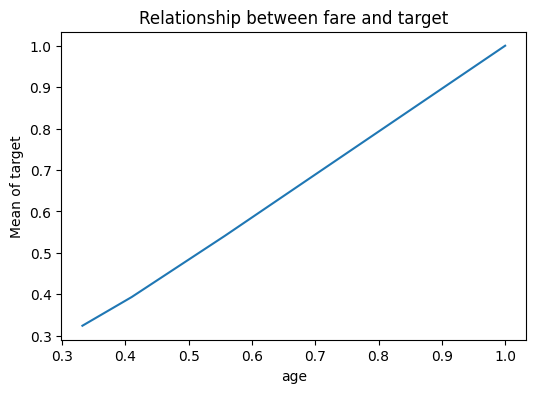

In [36]:
# The DecisionTreeDiscretiser() returns values which show
# a monotonic relationship with target

pd.concat([test_t, y_test], axis=1).groupby(
    'age')['survived'].mean().plot(figsize=(6, 4))

plt.ylabel("Mean of target")
plt.title("Relationship between fare and target")
plt.show()

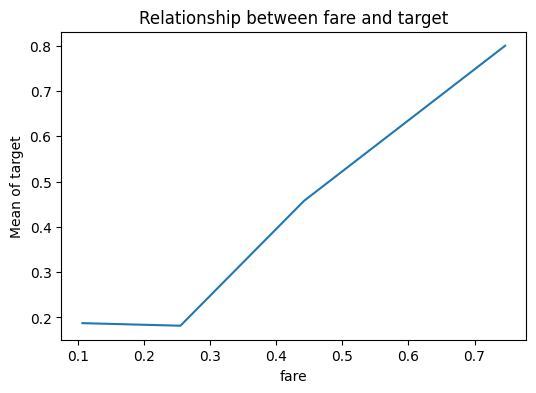

In [37]:
# The DecisionTreeDiscretiser() returns values which show
# a monotonic relationship with target

pd.concat([test_t, y_test], axis=1).groupby(
    'fare')['survived'].mean().plot(figsize=(6, 4))

plt.ylabel("Mean of target")
plt.title("Relationship between fare and target")
plt.show()

## DecisionTreeDiscretiser for Multi-class classification

In [38]:
# Load iris dataset from sklearn
from sklearn.datasets import load_iris

data = pd.DataFrame(load_iris().data, 
                    columns=load_iris().feature_names).join(
    pd.Series(load_iris().target, name='type'))

data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [39]:
data.type.unique() # 3 - class classification

array([0, 1, 2])

In [40]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop('type', axis=1),
                                                    data['type'],
                                                    test_size=0.3,
                                                    random_state=0)

print(X_train.shape)
print(X_test.shape)

(105, 4)
(45, 4)


In [41]:
#selected two numerical variables
X_train[['sepal length (cm)', 'sepal width (cm)']].dtypes

sepal length (cm)    float64
sepal width (cm)     float64
dtype: object

In [42]:
treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='accuracy',
                                   variables=[
                                       'sepal length (cm)', 'sepal width (cm)'],
                                   regression=False,
                                   random_state=29,
                                   )

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(random_state=29, regression=False, scoring='accuracy',
                        variables=['sepal length (cm)', 'sepal width (cm)'])

In [43]:
treeDisc.binner_dict_

{'sepal length (cm)': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [1, 2, 3, 4]}, scoring='accuracy'),
 'sepal width (cm)': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [1, 2, 3, 4]}, scoring='accuracy')}

In [44]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [45]:
# here I put side by side the original variable and the transformed variable
tmp = pd.concat([X_train[['sepal length (cm)', 'sepal width (cm)']],
                 train_t[['sepal length (cm)', 'sepal width (cm)']]], axis=1)

tmp.columns = ['sepal length (cm)', 'sepal width (cm)',
               'sepalLen_binned', 'sepalWid_binned']

tmp.head()

,sepal length (cm),sepal width (cm),sepalLen_binned,sepalWid_binned
60,5.0,2.0,0.125000,1.000000
116,6.5,3.0,0.296296,0.250000
144,6.7,3.3,0.296296,0.200000
119,6.0,2.2,0.296296,0.500000
108,6.7,2.5,0.296296,0.434783


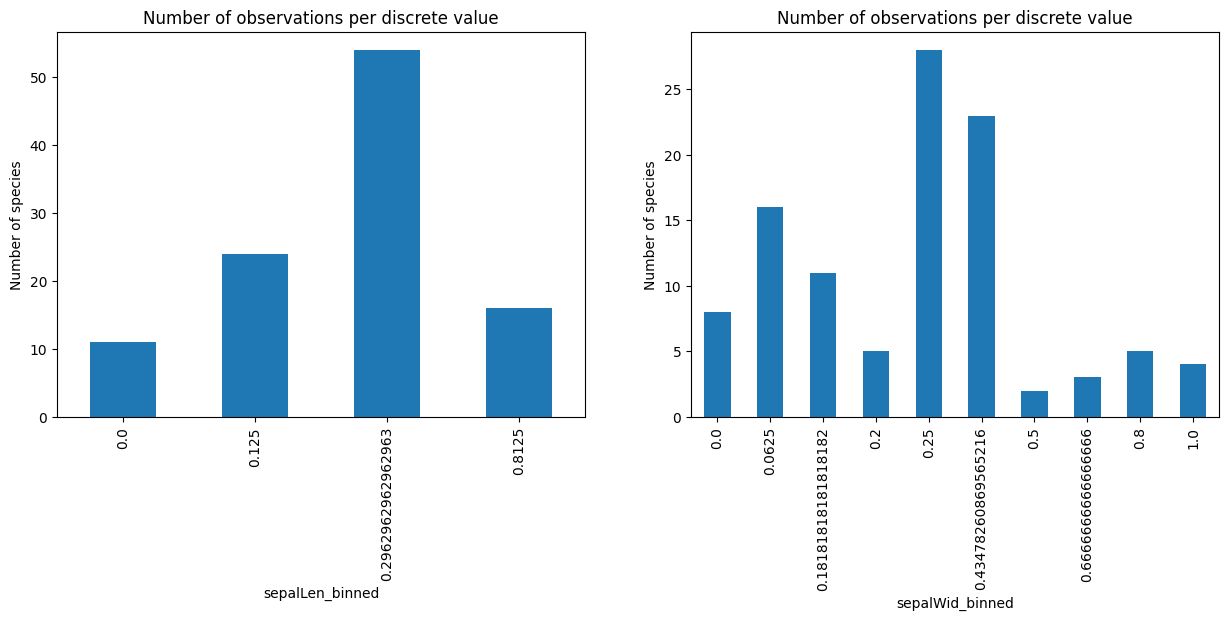

In [46]:
plt.subplot(1, 2, 1)
tmp.groupby('sepalLen_binned')['sepal length (cm)'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.subplot(1, 2, 2)
tmp.groupby('sepalWid_binned')['sepal width (cm)'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.show()